# "PSE stocks network analysis"
> "Stocks clumped together have more similar price movements at a given time"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Jerome de Leon
- categories: [network, visualization, correlation]

In [ ]:
# uncomment to install in colab
#!pip3 install fastquant

The network module is used to visualize (close price) correlations among PSE stocks between specified dates. The details of how the network is built is described in the next section. For now, let's see the features of the module.

In [3]:
from fastquant import Network 

['BH']: removed since <1/2 of original data is left after outlier rejection


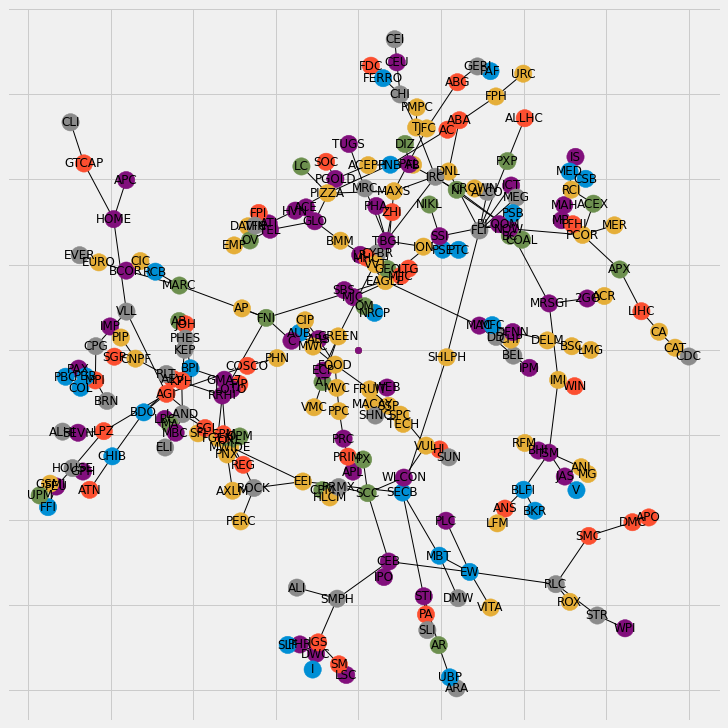

In [4]:
# initialize network
nw = Network()

# plot network of PSE blue chips
# each run may show different network representation
fig = nw.plot_network()

['BH']: removed since <1/2 of original data is left after outlier rejection


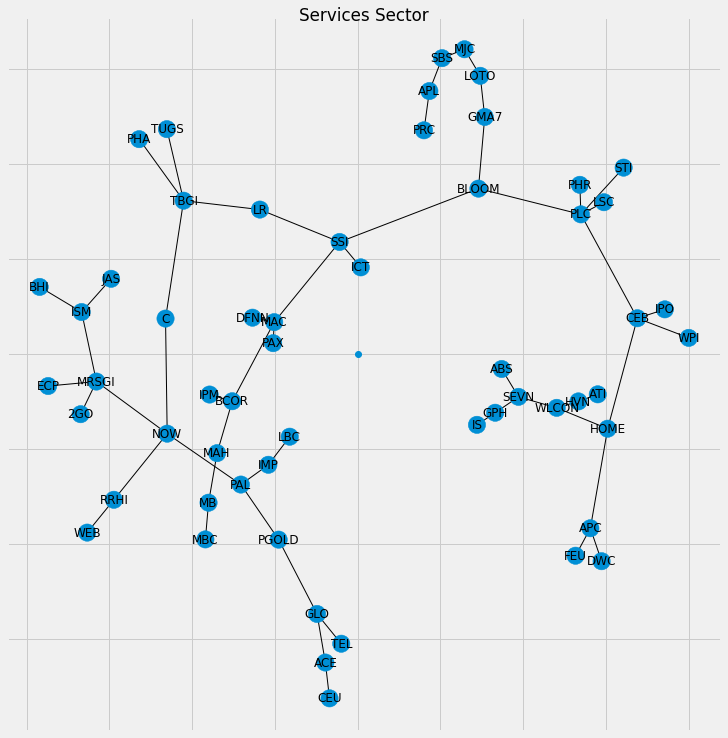

In [5]:
# show a specific sector
nw = Network(sector='Services')
fig = nw.plot_network()

In [6]:
nw.all_subsectors

['Transportation Services',
 'Property',
 'Holding Firms',
 'Media',
 'Electricity, Energy, Power & Water',
 'Oil',
 'Other Services',
 'Mining',
 'Hotel & Leisure',
 'Food, Beverage & Tobacco',
 'Retail',
 'Information Technology',
 'Banks',
 'Other Financial Institutions',
 'Casinos & Gaming',
 'Construction, Infrastructure & Allied Services',
 'Education',
 'Chemicals',
 'Electrical Components & Equipment',
 'Construction, Infra. & Allied Services',
 'Other Industrials',
 'ETF-Equity',
 'Telecommunications',
 'Small, Medium & Emerging Board',
 'Food Beverage & Tobacco']

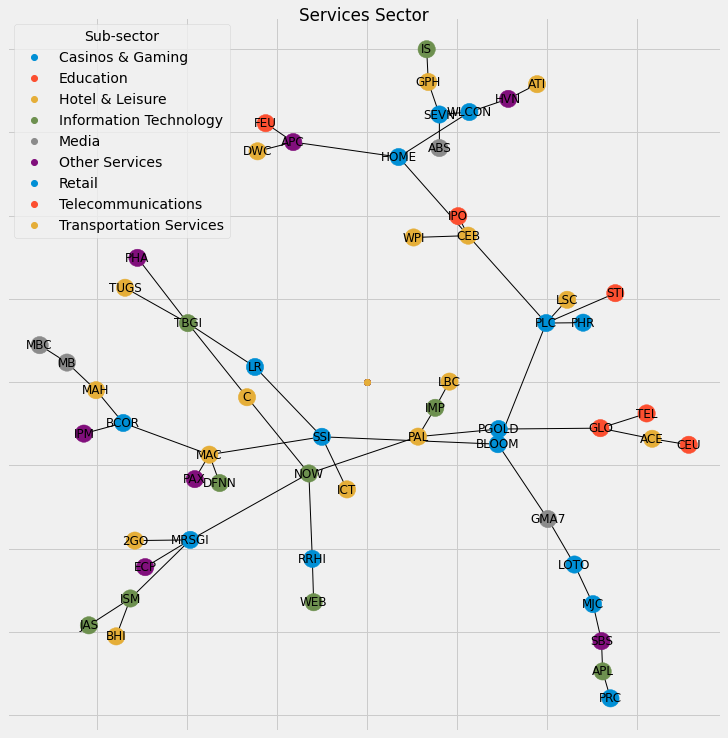

In [7]:
# show subsectors in the given sector
fig = nw.plot_network(show_subsector=True)

['BH']: removed since <1/2 of original data is left after outlier rejection


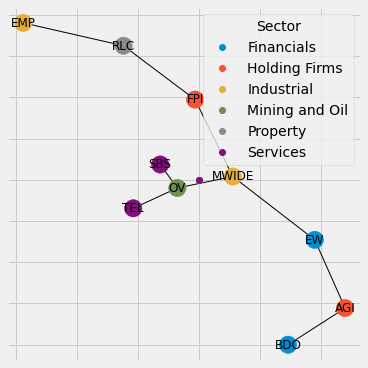

In [8]:
# focus on a specific stock
# if symbol is given, only top 5 positive and top 5 negative stocks are considered
nw = Network(symbol='BDO')

fig = nw.plot_network(figsize=(5,5))

In [9]:
# changing date changes correlations
nw = Network(symbol='BDO', 
             start_date='2019-01-01', 
             end_date='2020-04-01'
            )
nw.price_corr['BDO'].sort_values()

['AXLM' 'FRUIT' 'HOME']: removed since <1/2 of original data is left after outlier rejection


Symbol
TECH   -0.465283
EMP    -0.439232
FOOD   -0.358610
LOTO   -0.320371
TUGS   -0.318638
SECB    0.797003
RLC     0.849220
JGS     0.886634
SM      0.904801
BDO     1.000000
Name: BDO, dtype: float64

In [10]:
# compare to more recent date
nw = Network(symbol='BDO', 
             start_date='2020-01-01', 
             end_date='2020-04-01'
            )
nw.price_corr['BDO'].sort_values()

['BH' 'MJIC']: removed since <1/2 of original data is left after outlier rejection


Symbol
PRIM   -0.450445
EMP    -0.445236
SFI    -0.233569
FPI    -0.215350
LAND   -0.210225
RLC     0.973440
AGI     0.974241
FPH     0.975656
JFC     0.977932
BDO     1.000000
Name: BDO, dtype: float64

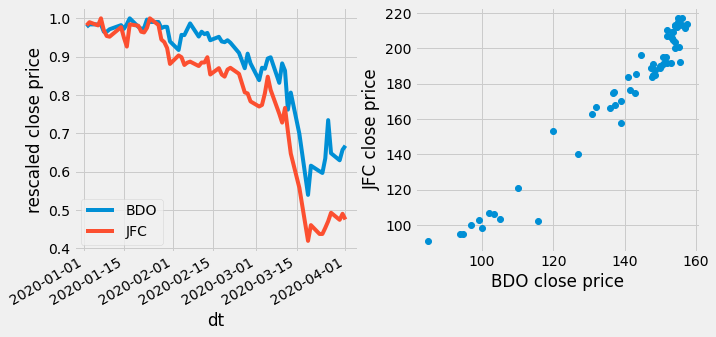

In [11]:
# compare with most correlated stock 
fig = nw.plot_corr_company(symbol='BDO')

Removed: ['PRIM']
['BH' 'MJIC']: removed since <1/2 of original data is left after outlier rejection


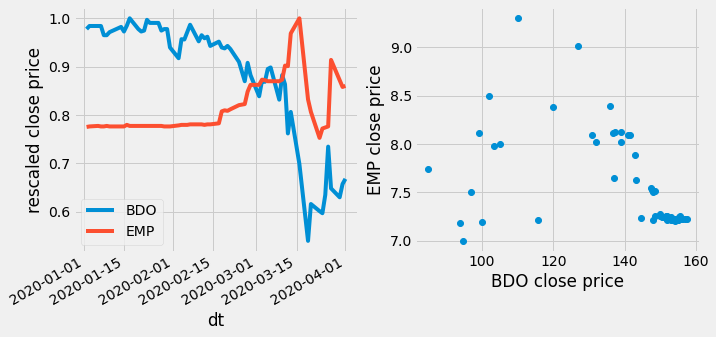

In [12]:
# remove specific stock e.g. PRIM because it appears noisy
nw = Network(symbol='BDO', 
             start_date='2020-01-01', 
             end_date='2020-04-01',
             exclude_symbols=["PRIM"]
            )

fig = nw.plot_corr_company(symbol='BDO', positive=False)

['BH' 'MJIC']: removed since <1/2 of original data is left after outlier rejection


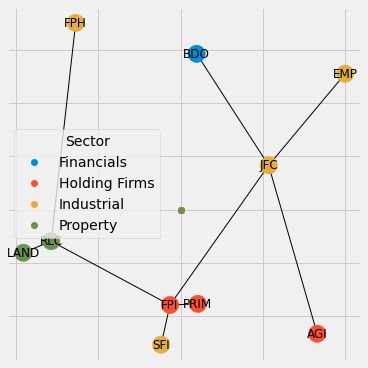

In [13]:
# specify distance metric: b for bonnano (default) or m for mktstk
nw = Network(symbol='BDO', 
             start_date='2020-01-01', 
             end_date='2020-04-01', 
             metric='m'
            )

fig = nw.plot_network(figsize=(5,5))

# Reconstruction

* This notebook uses fastquant to retrieve recent PH stock data 
* Then we implement stock network analysis, based on Dr. Legara's notebook [here](https://github.com/eflegara/FinancialNetwork/blob/master/Financial%20Network.ipynb), which includes:
  * Setting up the correlation matrix for the stock prices in the Philippine Stock Exchange
  * Converting the resulting correlation matrix into a distance matrix
  * Building a minimum spanning tree from the distance matrix
* The end result is a visual representation of network tree

In [14]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
import seaborn as sb
import networkx as nx
pl.style.use("default")

from fastquant import get_pse_data_cache, get_stock_data, DATA_PATH

## pull stock data using fastquant 

In [15]:
df = get_pse_data_cache()
df.tail()

Symbol       2GO                      ...    ZHI                         
            open  high    low  close  ...   high    low  close      value
dt                                    ...                                
2020-04-24  10.0  12.5   9.50  10.92  ...  0.170  0.150  0.160  2505390.0
2020-04-27  10.5  10.7   9.25   9.35  ...  0.160  0.152  0.159   248070.0
2020-04-28   9.1  10.0   8.60   9.40  ...  0.164  0.153  0.160    63580.0
2020-04-29   9.5  11.3   9.15  11.20  ...  0.159  0.150  0.159   126950.0
2020-04-30  10.7  12.2  10.50  10.60  ...  0.163  0.140  0.162  1607180.0

[5 rows x 1260 columns]

In [16]:
#choose only close column
df = df.xs('close', level=1, axis=1)
df.head()

Symbol,2GO,AAA,AB,ABA,ABG,ABS,AC,ACE,ACEPH,ACEX,ACR,AEV,AGI,ALCO,ALHI,ALI,ALLHC,ANI,ANS,AP,APC,APL,APO,APX,AR,ARA,AT,ATI,ATN,AUB,AXLM,BC,BCOR,BDO,BEL,BH,BHI,BKR,BLFI,BLOOM,...,SFI,SGI,SGP,SHLPH,SHNG,SLF,SLI,SM,SMC,SMPH,SOC,SPC,SPM,SSI,SSP,STI,STR,SUN,T,TBGI,TECH,TEL,TFC,TFHI,TUGS,UBP,UNI,UPM,URC,V,VITA,VLL,VMC,VUL,VVT,WEB,WIN,WLCON,WPI,ZHI
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,0.57,100.0,0.87,NaN,29.0,300.0,NaN,1.20,NaN,1.22,9.0,4.10,NaN,NaN,11.00,NaN,24.50,2.04,8.6,NaN,NaN,1.12,2.85,NaN,0.43,9.40,NaN,5.0,NaN,NaN,14.00,27.5,38.5,1.42,NaN,0.0875,NaN,NaN,NaN,...,0.15,NaN,NaN,NaN,1.72,NaN,NaN,325.0,68.0,9.7,2.26,NaN,NaN,NaN,NaN,NaN,NaN,0.49,3.70,3.4,NaN,2600.0,NaN,NaN,NaN,36.5,0.0975,0.0075,15.75,1.30,0.40,1.90,NaN,0.61,NaN,18.00,0.120,NaN,0.3,0.200
2010-01-05,1.14,0.46,100.0,0.87,NaN,29.0,300.0,NaN,1.26,NaN,1.22,9.1,4.15,0.18,8.3,10.75,0.41,24.25,2.08,8.8,0.35,NaN,1.22,2.80,0.0044,NaN,10.25,NaN,5.0,NaN,NaN,14.00,27.5,39.0,1.42,NaN,0.0900,1.24,1.30,10.0,...,0.15,0.88,NaN,NaN,1.72,1220.0,0.84,320.0,67.5,9.9,2.50,3.4,NaN,NaN,NaN,1.32,NaN,0.49,3.70,3.4,NaN,2630.0,NaN,NaN,NaN,37.0,0.1100,0.0090,15.50,1.30,0.40,1.88,NaN,0.68,NaN,18.25,0.120,NaN,NaN,0.210
2010-01-06,1.14,NaN,99.5,0.83,NaN,29.0,300.0,3.45,1.30,NaN,1.14,9.1,4.15,0.17,NaN,10.75,0.42,23.50,2.04,8.8,0.36,NaN,1.20,2.75,0.0044,NaN,10.50,NaN,5.0,NaN,NaN,13.75,NaN,39.0,1.42,NaN,0.0900,NaN,1.30,10.0,...,0.15,0.89,NaN,NaN,1.72,1250.0,0.80,325.0,67.0,9.9,2.44,3.0,NaN,NaN,NaN,1.36,NaN,0.50,3.70,3.5,NaN,2640.0,NaN,NaN,NaN,37.5,0.1150,0.0085,17.00,1.28,0.39,1.90,NaN,NaN,NaN,18.25,0.120,NaN,NaN,0.215
2010-01-07,1.14,0.42,100.0,0.84,NaN,29.0,297.5,3.00,1.26,NaN,1.28,9.1,4.35,0.17,8.3,11.25,0.45,25.50,2.06,8.9,0.37,NaN,1.20,NaN,0.0044,NaN,10.75,4.1,NaN,NaN,NaN,13.75,27.0,39.0,1.42,NaN,0.0925,NaN,NaN,9.5,...,0.15,0.88,NaN,NaN,NaN,1260.0,0.79,322.5,72.0,9.8,2.48,3.4,NaN,NaN,NaN,1.50,2.5,0.51,3.75,3.5,NaN,2690.0,NaN,NaN,NaN,37.5,0.1200,0.0090,17.25,1.30,0.41,1.92,NaN,NaN,NaN,18.25,0.115,NaN,0.3,0.200
2010-01-08,1.16,0.48,98.0,0.86,NaN,29.0,297.5,2.90,1.28,NaN,1.20,9.2,4.50,0.17,NaN,11.50,0.49,24.00,2.06,8.9,0.38,NaN,1.20,2.75,0.0044,NaN,11.25,NaN,NaN,NaN,NaN,13.75,NaN,39.0,1.44,250.0,0.0900,1.20,1.34,NaN,...,0.15,NaN,NaN,NaN,1.76,1255.0,0.78,325.0,72.0,9.8,2.44,NaN,NaN,NaN,NaN,1.36,NaN,0.54,3.75,3.6,NaN,2695.0,NaN,NaN,NaN,37.0,NaN,0.0085,18.00,1.28,NaN,2.00,NaN,0.66,NaN,18.25,0.115,NaN,NaN,0.220


In [17]:
#choose recent data
df = df[(df.index >= '2019-1-1') & (df.index <= '2020-1-1')]
df

Symbol,2GO,AAA,AB,ABA,ABG,ABS,AC,ACE,ACEPH,ACEX,ACR,AEV,AGI,ALCO,ALHI,ALI,ALLHC,ANI,ANS,AP,APC,APL,APO,APX,AR,ARA,AT,ATI,ATN,AUB,AXLM,BC,BCOR,BDO,BEL,BH,BHI,BKR,BLFI,BLOOM,...,SFI,SGI,SGP,SHLPH,SHNG,SLF,SLI,SM,SMC,SMPH,SOC,SPC,SPM,SSI,SSP,STI,STR,SUN,T,TBGI,TECH,TEL,TFC,TFHI,TUGS,UBP,UNI,UPM,URC,V,VITA,VLL,VMC,VUL,VVT,WEB,WIN,WLCON,WPI,ZHI
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,13.58,NaN,15.44,0.64,26.20,20.05,906.0,1.40,1.15,3.39,1.28,53.20,11.90,0.98,11.78,41.30,2.42,17.00,6.50,35.00,0.405,0.040,NaN,1.68,0.0020,1.72,2.65,14.68,1.44,59.35,NaN,1.45,3.43,127.0,2.35,NaN,NaN,1.48,2.11,9.64,...,0.128,1.33,NaN,47.00,NaN,NaN,1.24,915.5,147.3,37.00,NaN,5.48,2.25,2.42,1.44,0.78,5.36,0.73,0.86,0.445,31.80,1130.0,NaN,249.8,3.00,63.60,NaN,0.0059,127.5,NaN,1.92,5.41,2.33,1.54,NaN,3.82,0.260,13.06,0.77,0.220
2019-01-03,14.56,NaN,15.48,0.69,28.40,20.20,925.0,1.37,1.15,3.40,1.28,56.50,11.90,1.03,11.72,42.45,2.46,16.80,6.50,35.65,0.420,0.040,NaN,1.66,0.0020,1.71,2.80,14.02,1.45,59.50,NaN,NaN,3.54,129.5,2.39,NaN,NaN,1.48,2.14,9.87,...,0.125,1.32,NaN,47.20,3.12,1849.0,1.26,958.0,149.0,38.00,NaN,5.64,NaN,2.53,1.44,0.82,5.48,0.72,0.87,0.445,30.95,1158.0,NaN,249.8,3.23,64.00,NaN,0.0060,128.5,1.13,1.94,5.46,NaN,1.63,NaN,3.59,0.275,12.90,0.78,0.226
2019-01-04,14.34,NaN,16.50,0.71,27.50,20.35,960.0,1.34,1.16,NaN,1.29,57.00,11.80,1.00,11.68,43.70,2.45,16.94,6.50,35.70,0.420,0.039,NaN,1.69,0.0021,1.75,2.68,15.00,1.47,59.60,NaN,1.30,3.34,132.8,2.41,NaN,NaN,1.47,2.15,9.70,...,0.125,1.33,NaN,47.30,3.12,1850.0,1.36,946.0,145.3,38.50,0.74,6.09,NaN,2.52,1.50,0.81,5.61,NaN,0.88,0.450,31.80,1160.0,40.00,249.8,3.30,64.40,NaN,0.0082,128.5,NaN,1.94,5.60,NaN,1.66,NaN,3.45,0.260,13.40,0.77,0.226
2019-01-07,14.08,NaN,15.90,0.72,27.40,20.90,998.0,1.38,1.30,3.40,1.30,57.20,11.80,1.00,NaN,44.80,2.49,16.84,6.40,35.60,0.425,0.040,0.81,1.68,0.0021,1.74,2.71,14.98,1.46,59.60,NaN,1.30,3.43,129.5,2.45,NaN,NaN,1.46,2.18,10.12,...,NaN,1.34,NaN,47.50,3.15,NaN,1.41,940.0,146.5,38.95,0.74,6.07,NaN,2.51,1.54,0.79,5.75,0.73,0.89,0.450,31.30,1148.0,NaN,249.8,3.25,64.40,NaN,0.0076,130.5,1.16,1.88,5.69,NaN,1.62,NaN,3.55,0.255,14.00,0.78,0.224
2019-01-08,15.02,NaN,15.50,0.70,28.15,21.50,970.0,1.37,NaN,NaN,1.31,57.20,11.78,0.96,11.70,43.90,2.54,16.84,6.50,35.00,0.410,0.039,0.83,1.68,0.0020,1.74,2.70,14.98,1.43,59.50,NaN,NaN,3.45,129.0,2.38,NaN,NaN,1.51,2.10,10.00,...,0.126,1.40,484.0,47.55,3.12,1802.0,1.40,938.0,146.5,38.05,NaN,6.23,NaN,2.43,1.55,0.75,5.93,0.73,0.88,0.450,30.70,1140.0,NaN,250.0,3.26,64.35,NaN,0.0077,130.0,1.17,1.90,5.65,NaN,1.64,NaN,3.45,0.248,13.74,0.78,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,9.48,NaN,10.92,0.78,10.68,15.80,755.0,NaN,2.31,7.15,1.23,50.95,11.32,0.80,NaN,45.40,3.05,13.30,6.57,33.10,0.385,0.042,0.70,0.92,0.0015,1.42,2.40,18.26,0.92,53.90,2.46,NaN,4.38,154.8,1.98,NaN,NaN,0.85,2.09,11.30,...,NaN,1.22,172.0,33.35,3.18,NaN,2.48,1035.0,152.0,40.65,0.80,7.90,NaN,2.67,0.86,0.60,5.49,1.18,1.01,0.270,3.93,999.0,45.00,214.0,1.09,58.20,NaN,0.0052,143.0,NaN,1.13,7.35,NaN,0.88,15.30,2.35,0.202,18.16,0.57,0.190
2019-12-20,9.42,NaN,NaN,0.82,10.76,15.82,779.5,1.49,2.31,7.20,1.22,51.55,11.50,0.80,NaN,46.00,2.98,13.30,6.42,34.05,0.390,0.042,0.71,0.90,0.0015,1.30,2.41,18.00,0.93,53.50,2.54,NaN,4.50,155.4,1.97,NaN,NaN,NaN,NaN,11.26,...,0.115,1.22,175.0,33.30,3.10,1800.0,2.48,1065.0,158.0,41.45,NaN,8.20,NaN,2.68,0.89,0.63,5.48,1.17,1.00,0.275,3.82,1000.0,NaN,214.0,1.03,58.40,NaN,0.0053,144.0,1.08,1.12,7.30,NaN,0.89,15.14,2.43,NaN,17.84,0.60,0.209
2019-12-23,9.78,NaN,10.96,0.87,10.82,15.80,779.0,1.49,2.27,7.15,1.28,52.00,11.46,0.80,NaN,47.25,2.99,13.40,6.42,33.50,0.395,0.042,0.69,0.92,0.0015,1.36,NaN,NaN,0.94,53.25,2.58,NaN,

In [18]:
#remove columns with NaNs
df.dropna(axis=1, inplace=True)

## Build correlation matrix

In [19]:
price_corr = df.corr()

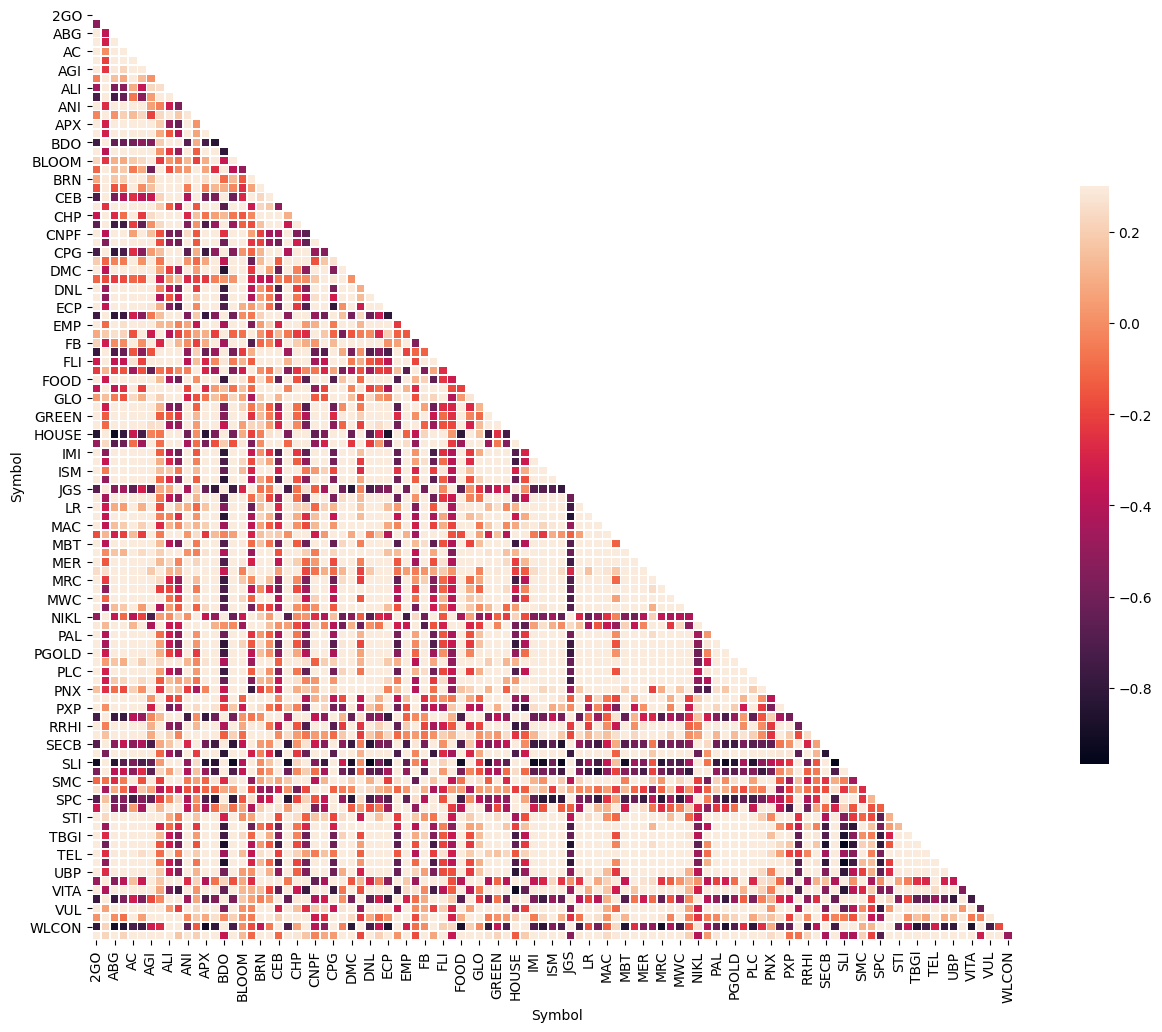

In [20]:
## Source: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html

## Generate a mask for the upper triangle
mask = np.zeros_like(price_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## Set up the matplotlib figure
fig, ax = pl.subplots(figsize=(15, 15))

## Generate a custom diverging colormap
# cmap = sb.diverging_palette(220, 10, as_cmap=True)

## Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(price_corr, mask=mask, vmax=.3, #cmap=cmap,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax
          )

In [21]:
def plot_corr(symbol, positive=True, rescale=True):
    corr = price_corr[symbol].sort_values(ascending=True)
    
    fig, ax = pl.subplots(1,2, figsize=(10,5))
    
    if positive:
        symbol2 = corr.index[-2]
    else:
        symbol2 = corr.index[0]
        
    if rescale:
        d1 = df[symbol]/df[symbol].max()
        d2 = df[symbol2]/df[symbol2].max()
        _ = d1.plot(ax=ax[0], label=symbol)
        d2.apply(lambda x: x).plot(ax=ax[0], label=symbol2)
    else:
        _ = df[symbol].plot(ax=ax[0], label=symbol)
        df[symbol2].plot(ax=ax[0], label=symbol2)
    ax[0].legend()

    ax[1].plot(df[symbol], df[symbol2], 'o')
    pl.setp(ax[1], xlabel=symbol, ylabel=symbol2)
    return fig    

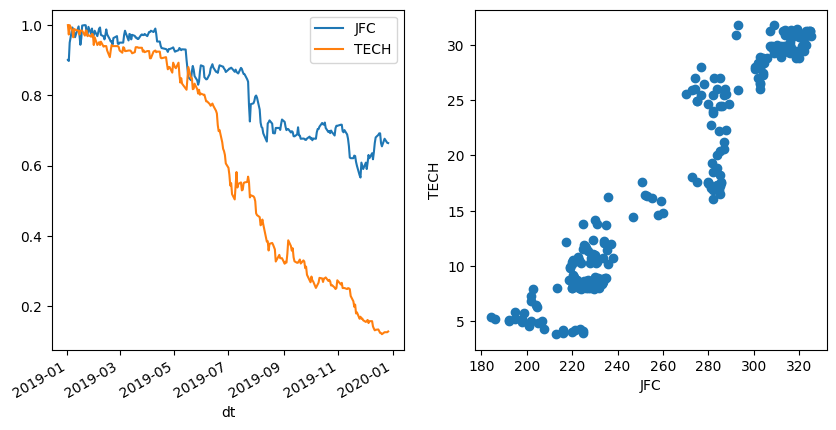

In [22]:
fig = plot_corr('JFC', positive=True);

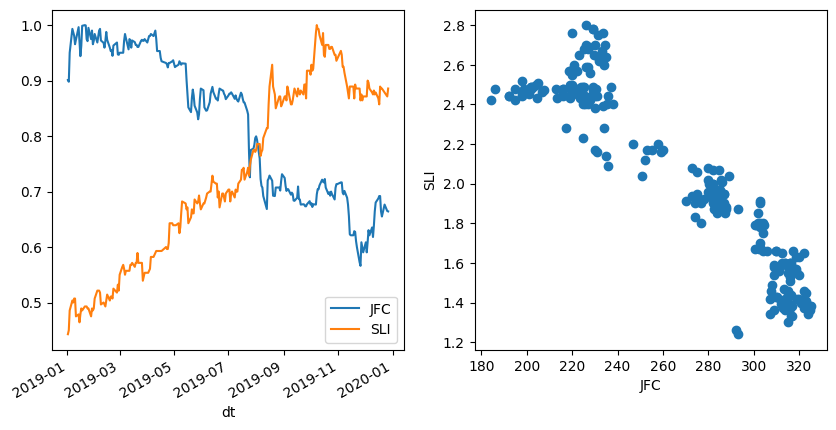

In [23]:
fig = plot_corr('JFC', positive=False);

## build distance matrix

In [24]:
dist_bonanno = np.sqrt(2*(1-price_corr))
dist_mktstk = 1-abs(price_corr)

labs_bonanno = list(dist_bonanno.index)
labs_mktstk = list(dist_mktstk.index)

## build minimum spanning tree

* PSE-listed company names are taken from [PSE](https://pse.com.ph/stockMarket/marketInfo-marketActivity.html?tab=1&indexName=All%20Shares) and saved as csv file.

In [25]:
G_bonanno = nx.from_numpy_matrix(dist_bonanno.values)
G_mktstk = nx.from_numpy_matrix(dist_mktstk.values)

In [26]:
MST_b = nx.minimum_spanning_tree(G_bonanno)  
MST_m = nx.minimum_spanning_tree(G_mktstk) 

In [27]:
stock_table = pd.read_csv(Path(DATA_PATH,'stock_table.csv'))
stock_table.head()

,Company Name,Stock Symbol,Sector,Subsector,Listing Date,company_id,security_id
0,"2GO Group, Inc.",2GO,Services,Transportation Services,"May 15, 1995",29,146
1,"8990 Holdings, Inc.",HOUSE,Property,Property,"Dec 09, 2010",626,563
2,"A Brown Company, Inc.",BRN,Property,Property,"Feb 08, 1994",13,234
3,A. Soriano Corporation,ANS,Holding Firms,Holding Firms,"Oct 25, 1973",14,169
4,ABS-CBN Corporation,ABS,Services,Media,"Jul 08, 1992",114,123


In [28]:
MST_b.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101))

In [29]:
for node in MST_b.nodes():
    sector = stock_table[stock_table["Stock Symbol"] == labs_bonanno[node]].Sector.iloc[0]
    MST_b.nodes[node]["sector"] = sector
    MST_b.nodes[node]["label"] = labs_bonanno[node]

In [30]:
for node in MST_m.nodes():
    sector = stock_table[stock_table["Stock Symbol"] == labs_mktstk[node]].Sector.iloc[0]
    MST_m.nodes[node]["sector"] = sector
    MST_m.nodes[node]["label"] = labs_mktstk[node]

## Drawing MSTs

In [31]:
def map_sector_to_color(graph, dtype='int'):
    sector_dict = nx.get_node_attributes(graph, 'sector')
    sector = pd.Series(sector_dict)
    if dtype=='int':
        return sector.astype('category').cat.codes.values
    elif dtype=='str':
        return sector.values
    elif dtype=='cat':
        # {int: str} mapping
        d = dict(enumerate(sector.astype('category').cat.categories))
        # {str: int} mapping (reverse)
        d = {v: k for k,v in d.items()}
        return d

In [32]:
def plot_network(graph, iterations=50, cmap=pl.get_cmap("Set1"), figsize=(10,10)):
    """
    Note: each instance may show different network structure 
    """
    fig = pl.figure(figsize=figsize, constrained_layout=True)
    nx.draw_networkx(graph, 
                     pos=nx.spring_layout(graph, iterations=iterations),
                     labels=nx.get_node_attributes(graph, 'label'),
                     node_color=map_sector_to_color(graph),
                     cmap=cmap,
                     font_color='k'
                    )
    #hack legend
    ColorLegend = map_sector_to_color(graph, dtype='cat')
    values = map_sector_to_color(graph, dtype='int')
    cNorm  = mpl.colors.Normalize(vmin=0, vmax=max(values))
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
    for label in ColorLegend:
        pl.plot([0],[0], 'o', 
                color=scalarMap.to_rgba(ColorLegend[label]), 
                label=label
               )
    pl.axis('off')
    pl.legend()
    return fig

Text(0.5, 0.98, 'bonano')

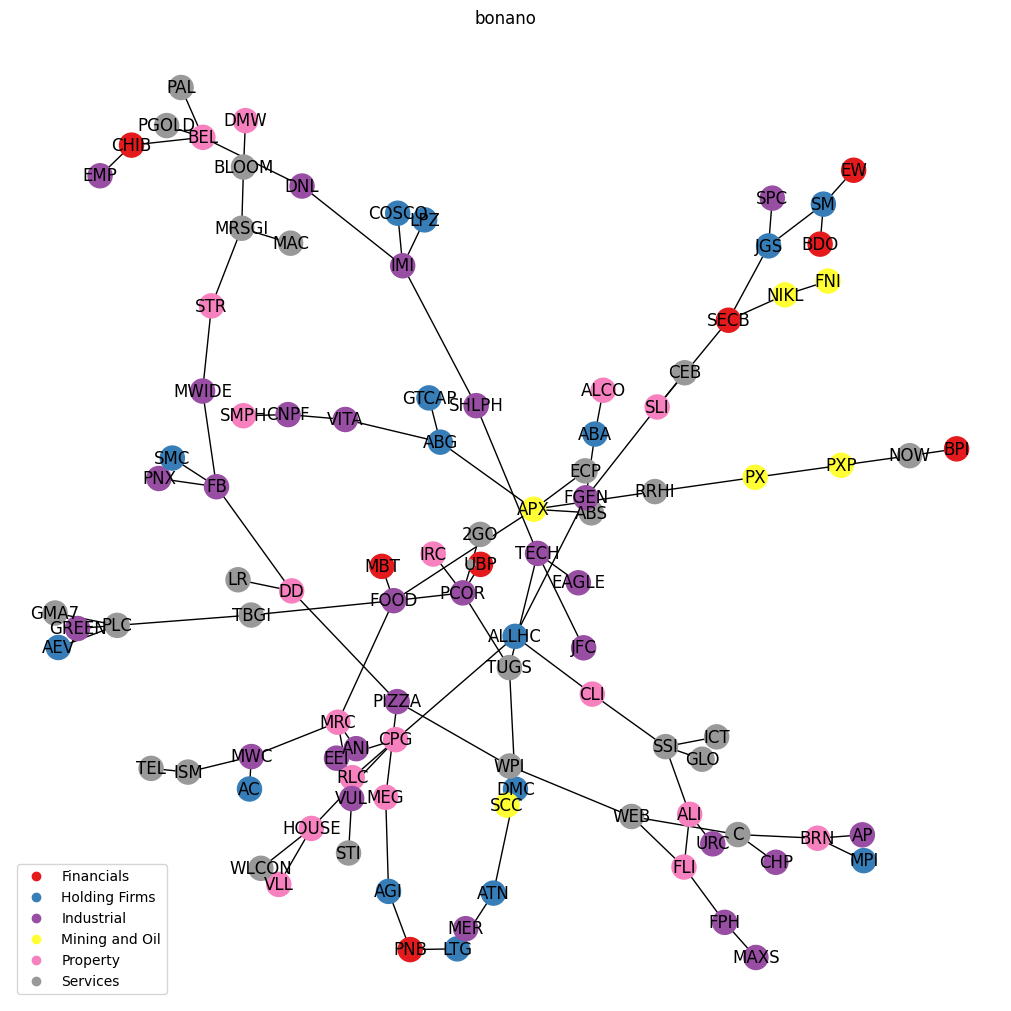

In [33]:
fig = plot_network(MST_b)
fig.suptitle('bonano')

Text(0.5, 0.98, 'mktstk')

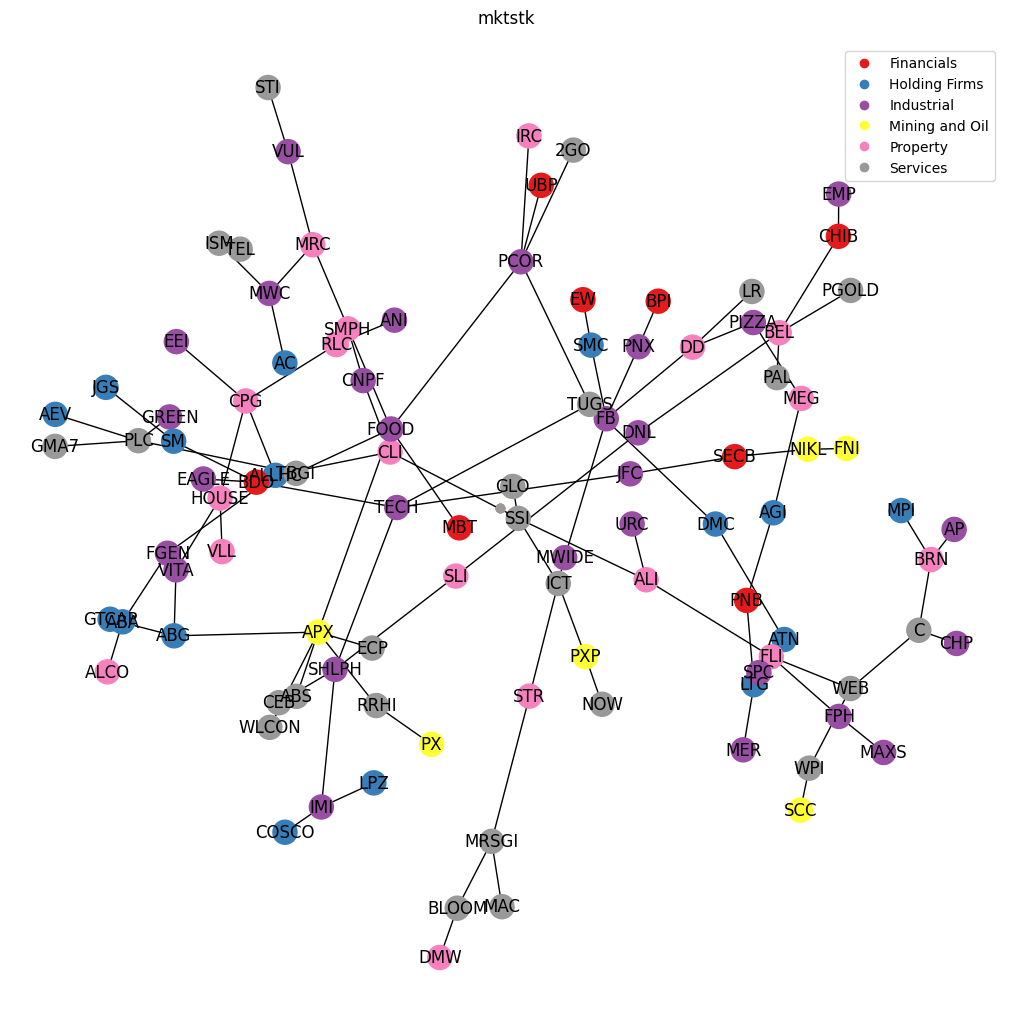

In [34]:
fig = plot_network(MST_m)
fig.suptitle('mktstk')

## Write out MSTs

In [35]:
nx.write_gexf(MST_b, Path(DATA_PATH,"corrmat_bonanno.gexf"))
nx.write_gexf(MST_m, Path(DATA_PATH,"corrmat_mktstk.gexf"))

# using sklearn (under development)
* https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py

In [36]:
import pandas as pd

fp = Path(DATA_PATH,'bluechips.txt')
bluechips = pd.read_csv(fp, delimiter='\t', names=['symbol','name'])
bluechips.head()

,symbol,name
0,DMC,"DMCI Holdings, Inc."
1,SCC,Semirara Mining and Power Corporation
2,AGI,"Alliance Global Group, Inc."
3,LTG,"LT Group, Inc."
4,MPI,Metro Pacific Investments Corporation


In [37]:
from fastquant import get_pse_data_cache, get_stock_data

cache = get_pse_data_cache()

#drop non-bluechips stocks
is_bluechips = cache.columns.levels[0].isin(bluechips.symbol)
columns = cache.columns.levels[0][~is_bluechips]
cache = cache.drop(columns=columns, level=0)

#choose recent data
df = cache[(cache.index > '2019-1-1') & (cache.index <= '2020-1-1')]
#drop stocks with NaNs
df.dropna(axis=1, inplace=True)
df.head()

Symbol         AC                       ...    URC                           
             open   high    low  close  ...   high    low  close        value
dt                                      ...                                  
2019-01-02  904.0  914.0  901.0  906.0  ...  128.5  125.7  127.5   37946221.0
2019-01-03  913.5  932.0  907.5  925.0  ...  128.8  127.2  128.5  125876349.0
2019-01-04  930.0  970.0  925.0  960.0  ...  130.5  127.5  128.5  448165602.0
2019-01-07  965.0  998.0  965.0  998.0  ...  131.7  129.3  130.5  357013830.0
2019-01-08  994.0  994.0  957.0  970.0  ...  131.3  129.5  130.0  222373222.0

[5 rows x 150 columns]

In [38]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold


open_prices = df.xs('open', level=1, axis=1)
close_prices = df.xs('close', level=1, axis=1)

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices


# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster {:d}: {}'.format((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

(-0.20017287981885576, 0.1399809716203011)

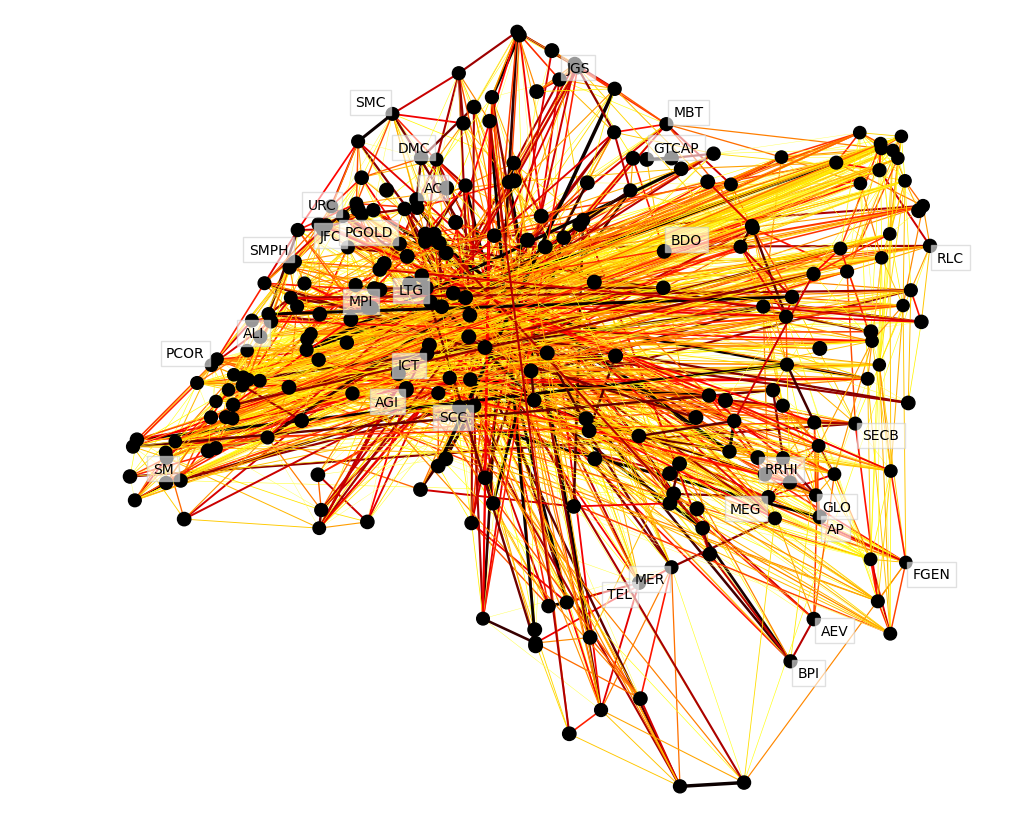

In [39]:
# #############################################################################
# Visualization
pl.figure(1, facecolor='w', figsize=(10, 8))
pl.clf()
ax = pl.axes([0., 0., 1., 1.])
pl.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
pl.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=pl.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=pl.cm.hot_r,
                    norm=pl.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(bluechips.symbol, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    pl.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=pl.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

pl.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
pl.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())